In [1]:
train_model = True
load_weights = False
make_labels = True
num = 15


import datetime
num_keypoints = 2
save_path = rf'F:\ET_Tube\CheXpert-v1.0\weights/test_weights_{datetime.datetime.now().strftime("%H:%M:%S")}.pth'
workbook_path = rf'F:\ET_Tube\CheXpert-v1.0\predictions_{datetime.datetime.now().strftime("%H:%M:%S")}.xlsx'

batch_size = 1
num_epochs = 10

In [2]:
KEYPOINTS_FOLDER_TRAIN = fr"C:\Users\nprim\Downloads\ET_TUBE.v{num}i.yolov7pytorch\train"
KEYPOINTS_FOLDER_TEST =  fr"C:\Users\nprim\Downloads\ET_TUBE.v{num}i.yolov7pytorch\test"

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import json, cv2, numpy as np, matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.models.detection import KeypointRCNN
import albumentations as A
import pandas as pd
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate
import random
import base64
from PIL import Image
from io import BytesIO
from IPython.display import HTML
from torchsummary import summary
import math
from openpyxl import Workbook
from openpyxl.drawing.image import Image as ExcelImage
from openpyxl.utils import get_column_letter
import glob
from natsort import natsorted
import itertools
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from tqdm import tqdm

In [4]:
print("Using torch", torch.__version__)
print(torch.cuda.is_available())

Using torch 1.13.1+cu117
True


In [9]:
if make_labels:
    import json
    import zipfile
    path_to_zip_file = fr"C:\Users\nprim\Downloads\ET_TUBE.v{num}i.yolov7pytorch.zip"
    BASE = fr"C:\Users\nprim\Downloads\ET_TUBE.v{num}i.yolov7pytorch"
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(BASE)


    #SET = ["/train", "/valid", "/test"]
    SET = ["/train",  "/test"]
    #SET = ["/train", "/valid"]
    #SET = ["/train"]
    #SET = ["/test"]

        
    keypoint_names =  ['Carina', 'ET']

    def dump2json(bboxes, keypoints_sorted, file_json):
        annotations = {}
        annotations['bboxes'], annotations['keypoints'] = bboxes, keypoints_sorted

        with open(file_json, "w") as f:
            json.dump(annotations, f)

    def converter(file_labels, file_image, keypoint_names):

        img = cv2.imread(file_image)
        img_w, img_h = img.shape[1], img.shape[0]
        
        with open(file_labels) as f:
            lines_txt = f.readlines()
            lines = []
            for line in lines_txt:
                lines.append([int(line.split()[0])] + [round(float(el), 5) for el in line.split()[1:]])
        
        bboxes = []
        keypoints = []

        # Convert normalized coordinates to absolute coordinates
        for line in lines:
            # Number 0 is a class of rectangles related to bounding boxes.
            if line[0] == 2:
                x_c, y_c, w, h = round(line[1] * img_w), round(line[2] * img_h), round(line[3] * img_w), round(line[4] * img_h)
                bboxes.append([round(x_c - w/2), round(y_c - h/2), round(x_c + w/2), round(y_c + h/2)])

            elif line[0] == 0 or line[0] == 1: #append all other keypoints without class change
                kp_id, x_c, y_c = line[0], round(line[1] * img_w), round(line[2] * img_h) 
                keypoints.append([kp_id, x_c, y_c])
                

        # iterating over each keypoint and looking to which bounding box it matches, dont need this for patellas
        keypoints_sorted = [[[] for _ in keypoint_names] for _ in bboxes]

        for kp in keypoints:
            kp_id, kp_x, kp_y = kp[0], kp[1], kp[2]
            for bbox_idx, bbox in enumerate(bboxes):
                x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
                if x1 < kp_x < x2 and y1 < kp_y < y2:
                    keypoints_sorted[bbox_idx][kp_id] = [kp_x, kp_y, 1] # All keypoints are visible
                    
        return bboxes, keypoints_sorted


    for i in range(len(SET)):
        IMAGES = BASE + SET[i] + "/images"
        LABELS = BASE + SET[i] + "/labels"
        ANNOTATIONS = BASE +  SET[i] + "/annotations"
        
        files_names = [file.split('.jpg')[0] for file in os.listdir(IMAGES)]

        for file in tqdm((files_names), desc =f"Set: {SET[i]}"):
        #for file in (files_names):
            file_labels = os.path.join(LABELS, file + ".txt")
            file_image = os.path.join(IMAGES, file + ".jpg")

            #img = cv2.imread(file_image)
            #if img.shape[0] != img.shape[1]:
                #print("Non square image:", file_image)
                
            bboxes, keypoints_sorted = converter(file_labels, file_image, keypoint_names)

            for i in keypoints_sorted:
                a,b = i
                if (len(a) != 3 or len (b) != 3) :
                    print("Error in file", file)

            if not os.path.exists(ANNOTATIONS):
                os.makedirs(ANNOTATIONS)

            dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS, file + '.json'))

Set: /test: 100%|██████████| 46/46 [00:01<00:00, 41.77it/s]


In [10]:
IMG_SIZE = 512

def train_transform():
    return A.Compose([
        A.Sequential([
            #A.RandomRotate90(p=5),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Rotate(p=0.5, limit = 20, border_mode=cv2.BORDER_CONSTANT, value=0),
            A.CLAHE(clip_limit=(1,4), p=1),
            #A.Resize(IMG_SIZE, IMG_SIZE, p=1)
        ], p=1)
    ],
    keypoint_params=A.KeypointParams(format='xy'), 
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels'])
    )

In [11]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))

        
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            
            bboxes_original = data['bboxes']
            keypoints_original = data['keypoints']
                          
            # All objects are patellas, so we can use the same label for all objects
            bboxes_labels_original = ['ROI' for _ in bboxes_original]  



            if self.transform:   
                # Converting keypoints from [x,y,visibility]-format to [x, y]-format + Flattening nested list of keypoints            
                # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
                # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]], where each keypoint is in [x, y]-format            
                # Then we need to convert it to the following list:
                # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2]
                
                keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]

                # Apply augmentations
                transformed = self.transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
                img = transformed['image']
                bboxes = transformed['bboxes']
                
                # Unflattening list transformed['keypoints']
                # For example, if we have the following list of keypoints for three objects (each object has two keypoints):
                # [obj1_kp1, obj1_kp2, obj2_kp1, obj2_kp2, obj3_kp1, obj3_kp2], where each keypoint is in [x, y]-format
                # Then we need to convert it to the following list:
                # [[obj1_kp1, obj1_kp2], [obj2_kp1, obj2_kp2], [obj3_kp1, obj3_kp2]]
                
                #keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,3,2)).tolist()

                keypoints_transformed_unflattened = [transformed['keypoints']]


                #keypoints_transformed_unflattened = np.reshape(np.array(transformed['keypoints']), (-1,3,2)).tolist()
                
                # Converting transformed keypoints from [x, y]-format to [x,y,visibility]-format by appending original visibilities to transformed coordinates of keypoints
                keypoints = []
                for o_idx, obj in enumerate(keypoints_transformed_unflattened): # Iterating over objects
                    obj_keypoints = []

                    for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                        # kp - coordinates of keypoint
                        # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                        obj_keypoints.append(np.array(kp).tolist() + [keypoints_original[o_idx][k_idx][2]])
                    keypoints.append(obj_keypoints)
        
            else:
                img, bboxes, keypoints = img_original, bboxes_original, keypoints_original
                 
            # Convert everything into a torch tensor        
            bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
            target = {}
            target["boxes"] = bboxes
            target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64)
            target["image_id"] = torch.tensor([idx])
            target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
            target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)

            target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32) 
            
            img = F.to_tensor(img)
            
            bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
            target_original = {}
            target_original["boxes"] = bboxes_original
            target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are patellas
            target_original["image_id"] = torch.tensor([idx])
            target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
            target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
            target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
            img_original = F.to_tensor(img_original)

            if self.demo:
                return img, target, img_original, target_original
            else:
                return img, target
    
    def __len__(self):

        return len(self.imgs_files)

In [12]:
dataset = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=train_transform(), demo=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
iterator = iter(data_loader)
batch = next(iterator)

In [13]:
keypoints_classes_ids2names = {0: 'Carina' , 1: 'ET'}

In [14]:
def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None, save = False, save_path = None, display=True):
    fontsize = 12

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 1, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 1, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(20,20))
        plt.imshow(image)
        

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (255,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 1, (255,255,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_PLAIN, 1, (255,0,0), 1, cv2.LINE_AA)
        
        f, ax = plt.subplots(1, 2, figsize=(10, 5))

    
        ax[0].set_title('Original image', fontsize=fontsize)
        ax[1].set_title('Predicted image', fontsize=fontsize) # also augmented image
        
        ax[0].imshow(image_original)
        ax[1].imshow(image)
            
        if(save):
            #print("Saving image to: ", save_path)
            plt.gcf().set_size_inches(2, 1)
            plt.savefig(save_path, dpi=100)
            plt.close()

In [15]:
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])



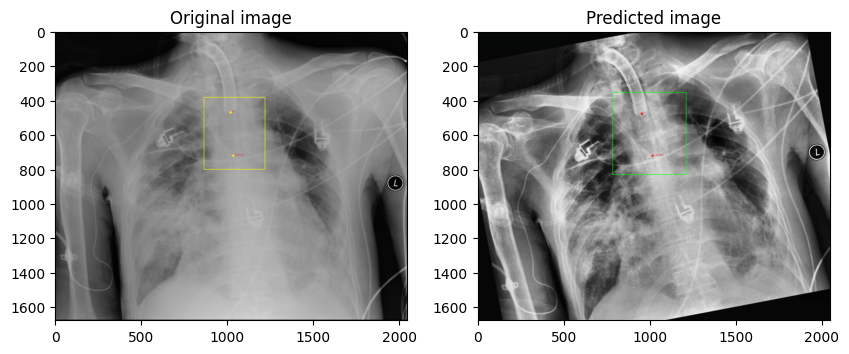

In [16]:
visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

In [17]:
def get_model(num_keypoints, weights_path=None):
    
    backbone = torchvision.models.convnext_large(weights='DEFAULT').features
    backbone.out_channels = 1536 # 1536 for convnext_large, 1024 for resnet50

    
    anchor_generator = AnchorGenerator(sizes=((64, 128, 256),), aspect_ratios=((0.5, 0.83, 2, 1.2),)) # these need to be tweaked for the very large dataset
    
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)
    keypoint_roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                             output_size=14,
                                                             sampling_ratio=2)

    model = KeypointRCNN(backbone,
                          num_classes=2,
                          rpn_anchor_generator=anchor_generator,
                          box_roi_pool=roi_pooler,
                          keypoint_roi_pool=keypoint_roi_pooler,
                          num_keypoints=num_keypoints,
                          max_size=1024)
    
    if weights_path:
        print("loading weights from: ", weights_path)
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

In [18]:
dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=train_transform(), demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=10, shuffle=False, collate_fn=collate_fn)

In [19]:
%%capture

if load_weights == True:    
    model = get_model(num_keypoints = 2, weights_path=save_path) # load saved weights
    print("Loaded weights from: ", save_path)
else:
    model = get_model(num_keypoints = 2)
    
model.to(device)

In [20]:
def calc_distance(kp1, kp2):
    x1, y1 = kp1
    x2, y2 = kp2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [21]:
def calc_epoch_error():
    with torch.no_grad():
        running_epoch_dist_error = 0
        num_keypoint_predictions = 0
        avg_dist_error = 0
        for images, targets in data_loader_test:
            images = list(image.to(device) for image in images)
            predictions = model(images)
            for i in range(len(predictions)):
                    for idx in range(num_keypoints):
                        try:
                            pred = predictions[i]['keypoints'][0][idx].detach().cpu().numpy().astype(np.int32)
                            x1,y1,_ = predictions[i]['keypoints'][0][idx].detach().cpu().numpy().astype(np.int32)
                            kp1 = (x1,y1)
                            x2,y2,_ = targets[i]['keypoints'][0][idx].detach().cpu().numpy().astype(np.int32)
                            kp2 = (x2,y2)
                            num_keypoint_predictions += 1
                            running_epoch_dist_error += calc_distance(kp1, kp2)
                            avg_dist_error = running_epoch_dist_error / num_keypoint_predictions
                        except:
                            print("No prediction for val image.")
        print("Running Epoch Error: ", avg_dist_error)

In [22]:
if train_model == True:
    print("Training model...")
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.8, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

    for epoch in range(num_epochs):
        train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
        lr_scheduler.step()
        evaluate(model, data_loader_test, device)
        #model.eval()
        #calc_epoch_error()
    torch.save(model.state_dict(), save_path)

Training model...
Epoch: [0]  [   0/1293]  eta: 3:16:08  lr: 0.000001  loss: 9.5062 (9.5062)  loss_classifier: 0.6545 (0.6545)  loss_box_reg: 0.0172 (0.0172)  loss_keypoint: 8.1564 (8.1564)  loss_objectness: 0.6778 (0.6778)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 9.1014  data: 0.0754  max mem: 5715
Epoch: [0]  [ 100/1293]  eta: 0:10:04  lr: 0.000051  loss: 8.8294 (9.2036)  loss_classifier: 0.2766 (0.4811)  loss_box_reg: 0.0162 (0.0211)  loss_keypoint: 7.8937 (8.0214)  loss_objectness: 0.6131 (0.6746)  loss_rpn_box_reg: 0.0052 (0.0055)  time: 0.4145  data: 0.0661  max mem: 9735
Epoch: [0]  [ 200/1293]  eta: 0:08:24  lr: 0.000101  loss: 7.1895 (8.5131)  loss_classifier: 0.0505 (0.2913)  loss_box_reg: 0.0097 (0.0178)  loss_keypoint: 6.8387 (7.6372)  loss_objectness: 0.3121 (0.5604)  loss_rpn_box_reg: 0.0044 (0.0064)  time: 0.4235  data: 0.0683  max mem: 9735
Epoch: [0]  [ 300/1293]  eta: 0:07:23  lr: 0.000151  loss: 7.3342 (8.0621)  loss_classifier: 0.0304 (0.2070)  loss_box_reg: 0.0064

In [ ]:
def calc_distance(kp1, kp2):
    x1, y1 = kp1
    x2, y2 = kp2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calc_mean_distance_error(real_keypoints, pred_keypoints):
    mean_distance = 0
    point_error = [0,0,0]
    assert len(real_keypoints) == len(pred_keypoints)
    for i in range(len(real_keypoints)):
        for j in range(len(real_keypoints[i])):
            point_error[j] = calc_distance(real_keypoints[i][j], pred_keypoints[i][j])
            mean_distance += point_error[j]
    return mean_distance/len(keypoints), point_error

In [ ]:
def get_best_keypoints(scores):
    avg_scores = []
    for score in scores:
        avg_scores.append(torch.mean(score))
    return avg_scores.index(max(avg_scores))

In [ ]:
import os

with torch.inference_mode():
    train_model = False
    if train_model == False:
        print("Loading model...")
        model.load_state_dict(torch.load(save_path))
    test_batch_size = 1
    data_loader_test = DataLoader(dataset_test, batch_size=test_batch_size, shuffle=True, collate_fn=collate_fn)

    iterator = iter(data_loader_test)

    total_mean_distance_error = 0
    total_point_error_list = []
    example_error_list = []
    pred_image_file_list = []
    total_number_of_predictions = 0
    no_preds_count = 0
    total_attempts = 0
    batch_count = 0 

    for item in iterator:
        
        try:
            images, targets = item
            images = list(image.to(device) for image in images)
            

        except StopIteration as e:
            print("StopIteration exception handled at batch: ", batch_count)
            
        
        model.to(device)            
        model.eval()
        output = model(images)   
        print("output: ", output)

        batch_count += 1 

        for prediction_number in range(len(images)):
            
            real_keypoints = [] #list of keypoints for each image in batch

            #unpacking the targets, this is a pain but works to remove the 0/1 visibility dim (which we do not need because all keypoints are visible)
            for kps in targets[prediction_number]['keypoints']:
                real_keypoints.append([list(map(int, kp[:2])) for kp in kps])
            distance_real = calc_distance(real_keypoints[0][0], real_keypoints[0][1])
            #print("Real keypoints: ", real_keypoints)
        
            
            real_bboxes = targets[prediction_number]['boxes'].int().tolist()
            
            #permute(1,2,0) converts the tensor to numpy array. The tensor is in the format (C, H, W) and numpy array is in the format (H, W, C).
            #detach().cpu().numpy() detaches the tensor from the graph and converts it to numpy array and moves it to CPU.
            image = (images[prediction_number].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)  
            
            scores = output[prediction_number]['scores'].detach().cpu().numpy()
            if len(scores) == 0:
                print("No keypoints found at image: ", prediction_number)
                no_preds_count += 1
                break


            high_scores_idxs = np.where(scores > 0.1)[0].tolist() # Indexes of boxes with scores > 0.1
            #print("High Score idxs: ", high_scores_idxs)
            #print("Raw NMS Boxes len: ", len(output[0]['boxes'][high_scores_idxs]))
            #print("Raw NMS scores len: ", len(output[0]['scores'][high_scores_idxs]))
            post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)
            #post_nms_idxs = 0
            print("-----------Post NMS idxs:-----------", post_nms_idxs)

            #Making images based on keypoints_scores, instead of bbox scores now
            #print("Raw Keypoint scores: ", output[prediction_number]['keypoints_scores'])
            keypoint_scores = output[prediction_number]['keypoints_scores'][post_nms_idxs]
            #print("Keypoint scores: ", keypoint_scores)
            #print("Keypoint scores: ", keypoint_scores)
            score_idx = get_best_keypoints(keypoint_scores)
            #print("Best Keypoints IDX: ", score_idx)
            #score_idx = 0
            pred_keypoints = []
            keypoints = output[prediction_number]['keypoints'][score_idx].detach().cpu().numpy()
        
            for kp in keypoints:
                kp = list(map(int, kp)) #convert (x,y) coords in each keypoint to int
                pred_keypoints.append(kp[:2])
            pred_keypoints = [pred_keypoints] #convert to list of lists to match real_keypoints format
            #print("Pred keypoints: ", pred_keypoints)

            distance_pred = calc_distance(pred_keypoints[0][0], pred_keypoints[0][1])
        

            bboxes = []
            
            #print("Boxes:", output[prediction_number]['boxes'][[0]][[0]])
            #print("Scores:", output[prediction_number]['scores'])
            for bbox in  output[prediction_number]['boxes'][[score_idx]][[0]].detach().cpu().numpy():
                bboxes.append(list(map(int, bbox.tolist())))
            
            
            if (len(bboxes) == 0):
                print("No bounding boxes found at image: ", prediction_number)
                no_preds_count += 1 #count preds with no bounding box at given threshold  
            else:
                total_number_of_predictions += 1    
                example_error, point_error = calc_mean_distance_error(real_keypoints, pred_keypoints)
                total_mean_distance_error += example_error
                
            
            total_attempts += 1
            
            example_point_error = [pt for pt in point_error]
            total_point_error_list.append(example_point_error)
            example_error_list.append(example_error)
            #print("Example error: ", example_error)
            
            save_img_path = f"F:\ET_Tube\saved_img_preds\prediction_{str(prediction_number)}_{str(batch_count)}.jpg"
            pred_image_file_list.append(save_img_path)
            visualize(image, bboxes, pred_keypoints, image_original=image, keypoints_original=real_keypoints, bboxes_original=real_bboxes, save=False, save_path = save_img_path, display=False)
            plt.savefig(save_img_path)
            #break
        #break
    total_mean_distance_error /= total_number_of_predictions
    print("Total mean Euclidean distance error: ", total_mean_distance_error)

    print("No predictions count: ", no_preds_count)
    print("Total attempts: ", total_attempts)
    print("Completed at: ", datetime.datetime.now().strftime("%H:%M:%S"))

In [ ]:
# Calculate the Fraction of Correct Keypoints (FCK)
# Threshold is the maximum distance between the predicted and ground truth keypoints
# Here it is written (default param) as 10 pixels
# Perhaps this should be a function of the image size?
def calculate_example_pck(total_point_error_list, threshold=10):
    num_correct = 0
    flat_list = list(itertools.chain(*total_point_error_list))

    for point in flat_list:
        if point <= threshold:
            num_correct += 1
            
# Calculate the FCK
    pck = num_correct / len(flat_list)
    return pck

pck_threshold_small = 10
pck_small = calculate_example_pck(total_point_error_list, threshold=pck_threshold_small)
print(f"Fraction of Correct Keypoints: {calculate_example_pck(total_point_error_list, threshold=pck_threshold_small):0.3f}, at a threshold of {pck_threshold_small} pixels.")

pck_threshold_large = 50
pck_large = calculate_example_pck(total_point_error_list, threshold=pck_threshold_large)
print(f"Fraction of Correct Keypoints: {calculate_example_pck(total_point_error_list, threshold=pck_threshold_large):0.3f}, at a threshold of {pck_threshold_large} pixels.")
pd.set_option('display.max_colwidth', None)

In [ ]:
def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((500, 250), Image.Resampling.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

df = pd.DataFrame(example_error_list, columns=['Example Error'])
df['pck_small'] = pck_small
df['pck_large'] = pck_large
df['file'] = pred_image_file_list
df['image'] = df.file.map(lambda f: get_thumbnail(f))
df.head()

HTML(df[['Example Error', 'image']].to_html(formatters={'image': image_formatter}, escape=False))


In [ ]:
workbook = Workbook()
worksheet = workbook.active

# resize cells
for row in range(2, len(df['file'])+2):
    for col in range(1,2):
        worksheet.row_dimensions[row].height = 400
        col_letter = get_column_letter(col)
        worksheet.column_dimensions[col_letter].width = 150
        
for col in range(2,50):
    col_letter = get_column_letter(col)
    worksheet.column_dimensions[col_letter].width = 30
         
# insert images
for index, image in enumerate(df['file']):
    if index == 0:
        worksheet.cell(row=index+1, column=1, value="Image")
        worksheet.add_image(ExcelImage(image), anchor='A'+str(index+2))
    else:
        worksheet.add_image(ExcelImage(image), anchor='A'+str(index+2))

excel_cell_values = []
for excel_cell_value in df['Example Error']:
    excel_cell_values.append(excel_cell_value)

for index, excel_cell_value in enumerate(excel_cell_values):
    if index == 0:
        worksheet.cell(row=index+1, column=2, value="Example Error")
        worksheet.cell(row=index+2, column=2, value=excel_cell_value)
    else:
        worksheet.cell(row=index+2, column=2, value=excel_cell_value)

# Find the last column
last_column = worksheet.max_column

# Add values to the last column
worksheet.cell(row=1, column=last_column+1).value = f'Total Mean Euclidean Distance Error: {total_mean_distance_error}'
worksheet.cell(row=2, column=last_column+1).value = f'No predictions count: {no_preds_count}'
worksheet.cell(row=6, column=last_column+1).value = f'Fraction of Correct Keypoints at threshold of {pck_threshold_small} pixels: {pck_small}'
worksheet.cell(row=7, column=last_column+1).value = f'Fraction of Correct Keypoints at threshold of {pck_threshold_large} pixels: {pck_large}'

# save workbook
workbook.save(workbook_path)

In [ ]:
def process_and_predict(image_file):
    raw_img = cv2.imread(image_file)
    aspect_ratio = raw_img.shape[0]/raw_img.shape[1]

    if aspect_ratio < 1.5 and aspect_ratio > 0.5:
        raw_img = cv2.resize(raw_img, (456, 456))
        test_img = np.moveaxis(raw_img, -1, 0)
        test_img= np.expand_dims(test_img, axis=0)
        test_img = torch.from_numpy(test_img).float().to(device)

        with torch.no_grad():
            model.to(device)            
            model.eval()
            output = model(test_img)
        
        scores = output[0]['keypoints_scores']
        score_idx = get_best_keypoints(scores)

        keypoints = output[0]['keypoints'][score_idx].detach().cpu().numpy()
        for idx, kp in enumerate(keypoints):
            current_keypoint = kp[:2].astype(int)
            raw_img = cv2.circle(raw_img, current_keypoint, 1, (255,255,0), 10)
            image_original = cv2.putText(raw_img, " " + keypoints_classes_ids2names[idx], current_keypoint, cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0), 2, cv2.LINE_AA)

        plt.figure(figsize=(10,10))
        plt.imshow(raw_img)
    else:
        print(f"Image aspect ratio is {aspect_ratio:0.2F} it but be between 0.5 - 1.5")

        
#test_img = "/mnt/c/Users/nprim/Downloads/F1.jpg"
#process_and_predict(test_img) # random picture from the internet